# Research Question 4:
Interpret if there is a bias in the data

RQ4: Is there a bias within the quotes and sentiment or rating of a movie w.r.t gender, ethnicity, etc.?

Possible Bias:
- Women tend to vote less on movies
- How successful are movies liked by men/women?
- Average vote by men?
- Young vs old generation? Which generation influences movie success the most?
- Bias per country??? (But Box office is limited to US only!)
- Bias on quote: Get gender of quoted person -> wikidata

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, pearsonr, ttest_ind, kstest
import statsmodels.api as sm
import statsmodels.formula.api as smf
from wikidata.client import Client
import pickle

## Are quotes in quotebank regarding movies biased?

We first aim to analyze how different genders are represented in the quotes regarding the movies. For this, we chose the highly represented top-quoted movies (about 10 per year), to get a meaningful number of quotes per movie, and also to analyze movies that are so popular that they potentially reach big parts of society (blockbusters), in order to analyze who makes quotes about his opinion about movies in general, and not just niche movies with a very limited interest group. 

In [3]:
df_quotes = pd.read_pickle('./exploratory/data/Quotebank_sentiment.pkl')
df_quotes.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID,AFINN_label,AFINN_score,VADER_label,VADER_score,BERT_label,BERT_score,positive_BERT_score,scaledReverted_BERT_score
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1751,POSITIVE,0.500000,POSITIVE,0.3612,NEGATIVE,0.989802,0.010198,-0.541032
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q38222, Q1507803]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,6724,POSITIVE,0.165563,POSITIVE,0.9910,POSITIVE,0.999293,0.999293,0.787788
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,692,NEGATIVE,-0.153846,NEGATIVE,-0.6369,NEGATIVE,0.833872,0.166128,-0.208302
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens,2394,POSITIVE,0.000000,NEGATIVE,-0.3612,NEGATIVE,0.991336,0.008664,-0.559515
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron,8789,NEGATIVE,-0.011111,POSITIVE,0.1901,POSITIVE,0.999218,0.999218,0.776419


In [4]:
df_quotes.shape

(70180, 17)

Our first approach to getting the gender of a speaker was a specialized python library that was able to estimate the gender of a speaker based on the first name, called `gender-guesser`. While it worked quite well for a majority of names, we found 2 shortcomings: First, it wasn't able to deal with all speakers we had available, as e.g. J.J. of J.J. Abrams couldn't be matched. Also, it supported an only binary approach to gender, which we also wanted to extend to also include non-binary genders. 

Hence, we instead decided to extract the gender from the given wikidata. For this, we first read the data in, and then check for the given qids for gender. We then use the library `wikidata` to get meaningful names for the gender qids. 

In [5]:
df_wikidata = pd.read_parquet('exploratory/data/speaker_attributes.parquet')

In [6]:
df_wikidata = df_wikidata.set_index('id')

In [7]:
df_wikidata.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion
id,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,George Washington,"[Q698073, Q697949]",item,[Q682443]
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Douglas Adams,None,item,None
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Paul Otlet,None,item,None
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Diego Velázquez,None,item,None


In [8]:
df_wikidata = df_wikidata.dropna(subset=['gender'])

In [9]:
df_wikidata['gender'] = df_wikidata['gender'].apply(lambda x: x[0])

In [10]:
df_wikidata['gender'].unique()

array(['Q6581097', 'Q6581072', 'Q1052281', 'Q2449503', 'Q48270',
       'Q1097630', 'Q12964198', 'Q189125', 'Q15145779', 'Q301702',
       'Q179294', 'Q27679766', 'Q18116794', 'Q859614', 'Q44148',
       'Q1289754', 'Q106299064', 'Q27679684', 'Q15145778', 'Q52261234',
       'Q207959', 'Q43445', 'Q505371', 'Q7130936', 'Q96000630',
       'Q1984232', 'Q93954933', 'Q746411', 'Q48279', 'Q3177577',
       'Q1775415', 'Q6636'], dtype=object)

In [11]:
client = Client()
qid_to_gender = dict()
for qid in df_wikidata['gender'].unique():
    if qid is not None:
        entity = client.get(qid, load=True)
        try:
            qid_to_gender[qid] = entity.data['labels']['en']['value']
        except:
            print(qid)
qid_to_gender

{'Q6581097': 'male',
 'Q6581072': 'female',
 'Q1052281': 'transgender female',
 'Q2449503': 'transgender male',
 'Q48270': 'non-binary',
 'Q1097630': 'intersex',
 'Q12964198': 'genderqueer',
 'Q189125': 'transgender person',
 'Q15145779': 'cisgender female',
 'Q301702': 'two-spirit',
 'Q179294': 'eunuch',
 'Q27679766': 'transmasculine',
 'Q18116794': 'genderfluid',
 'Q859614': 'bigender',
 'Q44148': 'male organism',
 'Q1289754': 'neutrois',
 'Q106299064': 'Erkek',
 'Q27679684': 'transfeminine',
 'Q15145778': 'cisgender male',
 'Q52261234': 'neutral sex',
 'Q207959': 'androgyny',
 'Q43445': 'female organism',
 'Q505371': 'agender',
 'Q7130936': 'pangender',
 'Q96000630': 'X-gender',
 'Q1984232': 'shemale',
 'Q93954933': 'demiboy',
 'Q746411': 'kathoey',
 'Q48279': 'third gender',
 'Q3177577': 'muxe',
 'Q1775415': 'feminine',
 'Q6636': 'homosexuality'}

In the following, we decided to keep male and female, and summarize other genders with a 'diverse' label. We so apply this to our dataframe of wikipedia properties.

In [12]:
df_wikidata['gender'] = df_wikidata['gender'].apply(lambda x: 'male' if x == 'Q6581097' else 'female' if x == 'Q6581072' else 'diverse')

In [13]:
def list_to_qid(x):
    try:
        return x[0]
    except:
        return None
df_wikidata['ethnic_group'] = df_wikidata['ethnic_group'].apply(list_to_qid)

In [14]:
df_wikidata['ethnic_group'].unique()

array([None, 'Q7994501', 'Q121842', ..., 'Q25659650', 'Q13324',
       'Q14167144'], dtype=object)

In [15]:
from wikidata.client import Client
client = Client()
for qid in df_wikidata['ethnic_group'].unique():
    if qid is not None:
        entity = client.get(qid, load=True)
        try:
            print(entity.data['labels']['en']['value'])
        except KeyError:
            print(entity.data)

White British
French
Poles
Greeks
Russians
Gujarati people
Kashmiri Pandit
Koreans
Asante people
Ashkenazi Jews
Germans
African Americans
Austrians
Armenian American
Italians
Japanese people
Han Chinese people
Roman people
Danes
Catholicism
Jews
Mongols
Swedes
Oromo people
Arabs
Indians
Scotch-Irish Americans
Hispano-Visigoths
Hans
Hong Kong American
Cantonese people
Americans
Hungarians
Hakka people
Italian American
Yoruba people
Norsemen
Serbs
English Canadian
Irish Americans
Pashtuns
white people
Turks
Bulgarians
English people
Sicilian American
indigenous peoples of the United States
Armenians
Oglala Lakota
Belarusians
Welsh people
Sephardi Jews
Jewish people of Ukraine
Norwegian Americans
Albanians
Ukrainians
Hima
Iranian Azerbaijanis
Merina people
Zakhchin
Tibetan people
Irish people
English American
Indians in Germany
Romanians
Banat Swabians
Croatian American
Czechs
{'pageid': 17540871, 'ns': 0, 'title': 'Q15916203', 'lastrevid': 1476619356, 'modified': '2021-08-09T06:33:36Z', 

Romanian
Irish Canadians
Irish Australian
Pontic Greeks
Korean Canadians
Te Āti Awa
Haida people
Ewe
Maltese
Rotuman people
Navajo
Ijaw people
Bunyoro
Aymara
Chamorro people
Transylvanian Saxons
Iranian Arabs
Aguaruna people
European Americans
Shan people
Northern Sámi people
American Australian
Australian Jews
Santa Clara Pueblo
Vietnamese American
Quraysh
Han
Ukrainian
Israelis
Yurok people
demographics of the United States
Akan people
Apache
{'pageid': 19721519, 'ns': 0, 'title': 'Q18191849', 'lastrevid': 447660869, 'modified': '2017-02-13T11:56:18Z', 'type': 'item', 'id': 'Q18191849', 'labels': {'he': {'language': 'he', 'value': 'יהודי'}}, 'descriptions': {'he': {'language': 'he', 'value': 'דמות מקראית, שם אדם המופיע בספר ירמיהו'}}, 'aliases': {}, 'claims': {'P21': [{'mainsnak': {'snaktype': 'value', 'property': 'P21', 'hash': '85ad4b1c7348f7a5aac521135040d74e91fb5939', 'datavalue': {'value': {'entity-type': 'item', 'numeric-id': 6581097, 'id': 'Q6581097'}, 'type': 'wikibase-entity

British African Caribbean people
Hupa
Yavapai-Apache Nation
Polish American
Meskwaki
Assyrians in Iraq
Ajam
Syrians
Ami
Russian Japanese
Hui people
mercheros
Atayal
Pataxó Hãhãhãe
White Brazilian
Scandinavian Brazilian
Portuguese Brazilians
Portuguese
Black people
Tay people
E De people
Moravian nationality
Tumed
Yaqui people
Mokshas
Bai people
Chamacoco
German Canadians
Norwegian and Swedish Travellers
Emishi
Quechuas
Warmian people
Moldovans
Portuguese American
Rusyns
Crimean Tatar
Hungarians in Ukraine
Banu Aws
Armenians in Jordan
Hutu
Galicians
Denpasar
Malaysian Chinese
Jewish
gypsy
Judaism
Yugoslavs
Greece
Occitans
Tamil people
Etruscans
Tufa clan
Montenegrins
Scottish Australian
Circassia
Torres Strait Islanders
Inupiat people
Feylis
Latino
Warumungu people
Dagbamba
Persian Jews
Dacians
Picts
Morisco
Armenians of Romania
Kaurna people
Confederated Tribes of the Umatilla Indian Reservation
Toro people
Jamaicans
Olcades
Ngāi Te Rangi
Tuareg people
Minangkabau people
Somali America

Jat Vidhan Sabha constituency
Bodo people
Singaporeans
Germans of Hungary
Indo-Trinidadians and Tobagonians
Kalinago
Muhajir
Hausa
Paez people
Haisla people
Innu people
Zaza people
Keraites
Swiss American
Jogezai
Scythians
Chinese Indonesians
Japanese Canadians
Acehnese people
Kakwa people
Luo people of Kenya and Tanzania
Nzakara
demographics of the Czech Republic
Peruvians
chicano
Lule Sámi people
Siksika Nation
Nepali people
Lebanese American
Cambeba people
Kumawat
Karen people
Wahpeton Dakota Nation
Nada
British Bangladeshi
Armenians in Lebanon
Hispanic peoples
Arab Canadians
Lakota people
Multiracial American
Udmurt people
South Asia
Ngāti Maniapoto
nisei
New Zealand European
Warlpiri people
Pitjantjatjara people
Kilamiut
Winnebago Tribe of Nebraska
Temne people
Moroccans
Acoma Pueblo tribe
Mixtec people
Venda people
Batak
Ndyuka people
Mununjali clan
Koreans in China
Caribbean people
Afro-Germans
Yaghan people
Nigerians
Bengali American
Malaysian Malay
Northern Cheyenne Tribe
Ngāt

Kukatja
Tunumiit
{'pageid': 83793629, 'ns': 0, 'title': 'Q84493931', 'lastrevid': 1110689365, 'modified': '2020-02-06T14:52:05Z', 'type': 'item', 'id': 'Q84493931', 'labels': {'nl': {'language': 'nl', 'value': 'Maisin'}}, 'descriptions': {'nl': {'language': 'nl', 'value': 'bevolkingsgroep uit Papua Nieuw-Guinea'}}, 'aliases': {}, 'claims': {'P31': [{'mainsnak': {'snaktype': 'value', 'property': 'P31', 'hash': 'aafeb487708c837828783185f818c2e267e444de', 'datavalue': {'value': {'entity-type': 'item', 'numeric-id': 41710, 'id': 'Q41710'}, 'type': 'wikibase-entityid'}, 'datatype': 'wikibase-item'}, 'type': 'statement', 'id': 'Q84493931$ea21eba4-47f1-9058-af37-80b9a029656f', 'rank': 'normal'}], 'P17': [{'mainsnak': {'snaktype': 'value', 'property': 'P17', 'hash': '5d28b60483b4f3580f3e873ca83315fb8bead154', 'datavalue': {'value': {'entity-type': 'item', 'numeric-id': 691, 'id': 'Q691'}, 'type': 'wikibase-entityid'}, 'datatype': 'wikibase-item'}, 'type': 'statement', 'id': 'Q84493931$f4af0f15

Bru people
San Diu people
{'pageid': 12047898, 'ns': 0, 'title': 'Q10773936', 'lastrevid': 1509502666, 'modified': '2021-10-08T17:07:23Z', 'type': 'item', 'id': 'Q10773936', 'labels': {'vi': {'language': 'vi', 'value': 'Jarai (định hướng)'}}, 'descriptions': {'es': {'language': 'es', 'value': 'página de desambiguación de Wikimedia'}, 'fr': {'language': 'fr', 'value': "page d'homonymie d'un projet Wikimédia"}, 'bn': {'language': 'bn', 'value': 'উইকিমিডিয়ার দ্ব্যর্থতা নিরসন পাতা'}, 'ca': {'language': 'ca', 'value': 'pàgina de desambiguació de Wikimedia'}, 'ckb': {'language': 'ckb', 'value': 'پەڕەی ڕوونکردنەوەی ویکیمیدیا'}, 'cs': {'language': 'cs', 'value': 'rozcestník na projektech Wikimedia'}, 'da': {'language': 'da', 'value': 'Wikimedia-flertydigside'}, 'de': {'language': 'de', 'value': 'Wikimedia-Begriffsklärungsseite'}, 'el': {'language': 'el', 'value': 'σελίδα αποσαφήνισης εγχειρημάτων Wikimedia'}, 'en': {'language': 'en', 'value': 'Wikimedia disambiguation page'}, 'en-ca': {'langu

Akkadians
Ukrainian American
Bani Assad
Lombards
Daylamites
Chinese community in India
Creoles of color
Guyanese in the United Kingdom
Jamaican American
Vietnamese Australian
Ghanaian American
Ukrainian Canadians
Serbs of Croatia
Polish minority in France
Hutsuls
Somba people
Brisgavi
Luxembourgers
Sardinian
Chinese people in Japan
Di
Ghanaians
Afro Argentines
Sinti
Romanians in Ukraine
Chiricahua
Sri Lankan American
France
Yakama Indian Nation
zambo
Japan
Spanish American
Indo-European
indigenous peoples in Ecuador
Croats of Bosnia and Herzegovina
Mohawks of Kahnawá:ke
Bagale Thapa
Anglo Indian people
Afro-Peruvian
Banu Abd-Shams
{'pageid': 1775734, 'ns': 0, 'title': 'Q1845111', 'lastrevid': 1368517185, 'modified': '2021-02-23T21:14:46Z', 'type': 'item', 'id': 'Q1845111', 'labels': {'nl': {'language': 'nl', 'value': 'Savoyaarden'}, 'fr': {'language': 'fr', 'value': 'Savoyard'}, 'ru': {'language': 'ru', 'value': 'Савояр'}, 'es': {'language': 'es', 'value': 'saboyardos'}}, 'descriptions

Lachi people
Roma
Marcomanni
Juden
Muong people
Gie Trieng people
Afro Trinidadians and Tobagonians
Balinese people
Ao Naga
Armenian
Kwakwaka'wakw
Huilliche people
Bangwaketse
Fipa people
Maasai
Samoans
Dusun
{'pageid': 3050576, 'ns': 0, 'title': 'Q3194398', 'lastrevid': 1368184189, 'modified': '2021-02-23T11:03:09Z', 'type': 'item', 'id': 'Q3194398', 'labels': {'fr': {'language': 'fr', 'value': 'Kayambis'}, 'qu': {'language': 'qu', 'value': 'Kayampi runa'}, 'hr': {'language': 'hr', 'value': 'Kayambi'}, 'sh': {'language': 'sh', 'value': 'Kayambi'}, 'es': {'language': 'es', 'value': 'kayambi'}}, 'descriptions': {'es': {'language': 'es', 'value': 'pueblo amerindio de Ecuador'}}, 'aliases': {}, 'claims': {'P31': [{'mainsnak': {'snaktype': 'value', 'property': 'P31', 'hash': '6d1b5897fc33edfa15a9929f9e354c4d66ed8bf1', 'datavalue': {'value': {'entity-type': 'item', 'numeric-id': 2472587, 'id': 'Q2472587'}, 'type': 'wikibase-entityid'}, 'datatype': 'wikibase-item'}, 'type': 'statement', 'id'

Crimean Karaites
Alakozai
Muslim Rajputs
Chindian
Thai American
{'pageid': 14774102, 'ns': 0, 'title': 'Q13178194', 'lastrevid': 133658467, 'modified': '2014-05-25T21:25:02Z', 'type': 'item', 'id': 'Q13178194', 'labels': {'nan': {'language': 'nan', 'value': 'Taiwaner'}}, 'descriptions': {}, 'aliases': {'nan': [{'language': 'nan', 'value': 'Taiwanian'}]}, 'claims': {}, 'sitelinks': {'zh_min_nanwiki': {'site': 'zh_min_nanwiki', 'title': 'Taiwaner', 'badges': [], 'url': 'https://zh-min-nan.wikipedia.org/wiki/Taiwaner'}}}
White Hispanic and Latino Americans
Russian Chinese
British Jews
Tapieté
Mariche people
Bubi people
Mapudungun
Islam in Sri Lanka
Black people in France
Hoklo people
Caribbean
South Korea
Macanese people
Portuguese Canadians
Lower Brule Sioux Tribe
Chaga people
Yawuru people
Yemenite Jews
Nair
Kerala
Guyanese
Cape Coloureds
Basque Argentine
Mongols in China
Volksdeutsche
quilombola
South Asian American
Kam people
Gyalrong people
Pima Bajo
Bulgarians in Serbia
Slavic speak

Castizo
Sidhu
The Sligo Champion
Persians in Bahrain
Niyogi
Maronites
Tahitians
Zvhil
Mon people
Trinidadians and Tobagonians
Balooshi people
Burmese Indians
Toraja
Wiyot people
Japanese Australian
Ohkay Owingeh
Wea
Choros
Trinidadian and Tobagonian American
Ukrainians of Romania
Ojibways of Onigaming First Nation
Lozi people
Qibi
naturalized Japanese citizens of Chinese origin
Gorals
Americans in Germany
{'pageid': 14169945, 'ns': 0, 'title': 'Q12781266', 'lastrevid': 1437278633, 'modified': '2021-06-07T21:20:17Z', 'type': 'item', 'id': 'Q12781266', 'labels': {'sk': {'language': 'sk', 'value': 'Česká'}, 'cs': {'language': 'cs', 'value': 'Česká'}}, 'descriptions': {'sk': {'language': 'sk', 'value': 'rozlišovacia stránka'}, 'es': {'language': 'es', 'value': 'página de desambiguación de Wikimedia'}, 'fr': {'language': 'fr', 'value': "page d'homonymie d'un projet Wikimédia"}, 'bg': {'language': 'bg', 'value': 'Уикимедия пояснителна страница'}, 'en': {'language': 'en', 'value': 'Wikimedia 

Sudanese
Kosovars
Mwera people
Negro
Iban people
Squamish people
Indo-Surinamese
Siddi
Munduruku people
Tamil
Cebuano people
Kokama
Algerians
Adavi
Shakya
Arab Brazilian
Tamil Brahmin
Kuban Cossacks
Manx people
Afsharid dynasty
Australia
Arab
German Texan
amaqaba
Wajin
Gros Ventre people
Vlah
German Chilean
T'satsąot'ınę
Kongo people
Japanese
Banu 'Amir
Eora
Iranian Canadian
Teke people
Bihari people
Converso
Blood
South Asian ethnic groups
European Canadians
Wurundjeri
Suebi
Yankton
Palestinian Jews
Romanian Jews in Israel
Umayyad dynasty
Madhesi people
Black Puerto Rican
Irish Quebecers
{'pageid': 101392775, 'ns': 0, 'title': 'Q106076409', 'lastrevid': 1386243344, 'modified': '2021-03-20T10:02:33Z', 'type': 'item', 'id': 'Q106076409', 'labels': {'ru': {'language': 'ru', 'value': 'евреи в Норвегии'}}, 'descriptions': {'ru': {'language': 'ru', 'value': 'этническая группа'}, 'nl': {'language': 'nl', 'value': 'etnische groep'}}, 'aliases': {'ru': [{'language': 'ru', 'value': 'норвежские 

Puyuma people
Schlesien
Mandaeans
Jew
Ghegs
Banu Khuza'a
Galician Germans
Bukharan Jews
Sabines
Kyrgyz
Lucumi people
Maghrebi Jews
Sonowal Kacharis
Yuki people
{'pageid': 12046042, 'ns': 0, 'title': 'Q10772083', 'lastrevid': 1509534391, 'modified': '2021-10-08T18:59:46Z', 'type': 'item', 'id': 'Q10772083', 'labels': {'vi': {'language': 'vi', 'value': 'Hồi'}}, 'descriptions': {'es': {'language': 'es', 'value': 'página de desambiguación de Wikimedia'}, 'fr': {'language': 'fr', 'value': "page d'homonymie d'un projet Wikimédia"}, 'bn': {'language': 'bn', 'value': 'উইকিমিডিয়ার দ্ব্যর্থতা নিরসন পাতা'}, 'ca': {'language': 'ca', 'value': 'pàgina de desambiguació de Wikimedia'}, 'ckb': {'language': 'ckb', 'value': 'پەڕەی ڕوونکردنەوەی ویکیمیدیا'}, 'cs': {'language': 'cs', 'value': 'rozcestník na projektech Wikimedia'}, 'da': {'language': 'da', 'value': 'Wikimedia-flertydigside'}, 'de': {'language': 'de', 'value': 'Wikimedia-Begriffsklärungsseite'}, 'el': {'language': 'el', 'value': 'σελίδα αποσ

Besermyan
Bedoun
Cham Albanians
Karakalpaks
Beylik of Germiyan
Sui people
Karamanlides
Pied-Noir
Malaysian Australian
Karenni people
Ngāti Kahu
Kokang people
Armenians in Mexico
Ukwuani people
Obotrites
Brothertown Indians
xueta
Pipil people
gaucho
Vietnamese people in France
Slovincians
Aequi
Syrian Turkmen
Japanese German
Thailand
Lower Elwha Klallam Tribe
Mangue people
Jaga
Albanians in North Macedonia
Balts
Guadeloupe-Martinique Creole French
Stanikzai
Susu people
Ngāti Toa
Grenadians
American Mexicans
Tanana Athabaskans
Maricopa people
Greeks in Hungary
British Jamaican
Romani people in Hungary
mixed-sex sports
Afros
Croatian Australian
{'pageid': 6689937, 'ns': 0, 'title': 'Q6837434', 'lastrevid': 1438448218, 'modified': '2021-06-09T19:58:12Z', 'type': 'item', 'id': 'Q6837434', 'labels': {'vi': {'language': 'vi', 'value': 'Người Thổ'}, 'zh': {'language': 'zh', 'value': '土族 (消歧义)'}, 'yue': {'language': 'yue', 'value': '土族'}}, 'descriptions': {'es': {'language': 'es', 'value': 'pág

Polish Australians in Melbourne
Bantenese
Opata people
H're people
Diaguitas
Nlaka'pamux
German diaspora
Haratin
Cameroon
Moluccans
Haitian
Swahili culture
Ngbaka people
Polish Australian
Hualapai
Molokans
Tl'azt'en Nation
Ngarigo people
Tharawal
Kist
Mozabite people
Gujarati Americans
Burarra
Plains Cree
Saginaw Chippewa Tribal Nation
Ancient Pueblo Peoples
English River First Nation
Kaqchikel people
Malawians
Zimbabweans
Wappo people
Scandinavians
Russians in Belarus
Moroccan-Dutch
Romani
Bengali Muslims
Canarian Americans
Mexican Canadians
Absentee-Shawnee Tribe of Indians
Persian
Basque Colombians
Nambé people
Harakmbut people
Ngāti Kurī
Southern Ngāti Raukawa
Ngāti Apakura
Minangkabau
Ijaw


To further investigate, we create a dataframe to map our shared_IDs with their gender. We give these shared_IDs to a set of qids referring to the same person (e.g. Donald Trump, President Trump, etc.). To get the gender, we decided to check all qids and stop after the first match (assuming that each article gives the same gender to a person, if any). 

In [16]:
map_gender = df_quotes[['shared_ID', 'qids']].drop_duplicates(subset=['shared_ID'])
map_gender.head()

,shared_ID,qids
0,1751,[Q16843606]
1,6724,"[Q38222, Q1507803]"
2,692,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619..."
3,2394,[Q188137]
4,8789,[Q515161]


In [17]:
map_gender.shape

(13440, 2)

In [18]:
def get_gender(row):
    for qid in row['qids']:
        try:
            gender = df_wikidata.loc[qid, 'gender']
            row['gender'] = gender
            return row
        except KeyError:
            continue
    row['gender'] = None
    return row
map_gender = map_gender.apply(get_gender, axis=1)

In [19]:
map_gender['gender'].value_counts()

male       10639
female      2555
diverse       35
Name: gender, dtype: int64

In [20]:
map_gender = map_gender.set_index('shared_ID')

In [21]:
df_quotes = df_quotes.merge(map_gender, how='left', left_on='shared_ID', right_index=True)
df_quotes.head()

,quotation,speaker,qids_x,date,numOccurrences,probas,urls,movie,shared_ID,AFINN_label,AFINN_score,VADER_label,VADER_score,BERT_label,BERT_score,positive_BERT_score,scaledReverted_BERT_score,qids_y,gender
0,Is Ferguson like Mockingjay?,Laci Green,[Q16843606],2015-11-15,1,"[[Laci Green, 0.9013], [None, 0.0987]]",[http://www.dailykos.com/story/2015/11/15/1450...,The Hunger Games: Mockingjay - Part 2,1751,POSITIVE,0.500000,POSITIVE,0.3612,NEGATIVE,0.989802,0.010198,-0.541032,[Q16843606],female
1,I want to clarify my interview on the `Charlie...,George Lucas,"[Q38222, Q1507803]",2015-12-31,7,"[[George Lucas, 0.5327], [None, 0.4248], [Char...",[http://www.escapistmagazine.com/news/view/165...,Star Wars: Episode VII - The Force Awakens,6724,POSITIVE,0.165563,POSITIVE,0.9910,POSITIVE,0.999293,0.999293,0.787788,"[Q38222, Q1507803]",male
2,Is Daredevil joining the Avengers for Infinity...,Scott Davis,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",2015-12-10,2,"[[None, 0.4806], [Scott Davis, 0.4017], [Antho...",[http://www.flickeringmyth.com/2015/12/is-dare...,Avengers: Age of Ultron,692,NEGATIVE,-0.153846,NEGATIVE,-0.6369,NEGATIVE,0.833872,0.166128,-0.208302,"[Q1373440, Q7436227, Q7436228, Q7436226, Q1619...",male
3,"They were saying, `Well, since when has Star W...",J.J. Abrams,[Q188137],2015-12-21,1,"[[J.J. Abrams, 0.5868], [None, 0.2584], [Lupit...",[http://rssfeeds.usatoday.com/~/129385923/0/us...,Star Wars: Episode VII - The Force Awakens,2394,POSITIVE,0.000000,NEGATIVE,-0.3612,NEGATIVE,0.991336,0.008664,-0.559515,[Q188137],male
4,You meet new characters and you learn about Ha...,Kevin Feige,[Q515161],2015-05-06,1,"[[Kevin Feige, 0.9108], [None, 0.0782], [Scott...",[http://www.digitaltrends.com/movies/ant-man-m...,Avengers: Age of Ultron,8789,NEGATIVE,-0.011111,POSITIVE,0.1901,POSITIVE,0.999218,0.999218,0.776419,[Q515161],male


In [22]:
df_quotes['gender'].value_counts()

male       57332
female     12176
diverse      127
Name: gender, dtype: int64

<AxesSubplot:ylabel='gender'>

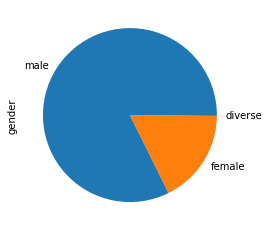

In [23]:
df_quotes['gender'].value_counts().plot.pie()

In [24]:
df_quotes.drop_duplicates('shared_ID')['gender'].value_counts()

male       10639
female      2555
diverse       35
Name: gender, dtype: int64

<AxesSubplot:ylabel='gender'>

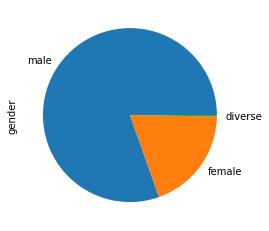

In [25]:
df_quotes.drop_duplicates('shared_ID')['gender'].value_counts().plot.pie()

First interesting finding: A HUGE majority of quotes come from speakers who identify as male, nearly 5 times as much as from women. Other genders are a very small minority. This is pretty outstanding, as one would rather expect male and female to be at about 50 % each. As about 1.2 million of a total of 300 million Americans identify as non-binary (https://williamsinstitute.law.ucla.edu/publications/nonbinary-lgbtq-adults-us/), we would assume the same about 0.4 % of non-binary people, while here we get only 0.1 % of quotes from people identifying as non-binary. We would conclude that mostly women might be underrepresented. 
The same holds for the number of unique speakers. Only 35 are diverse, and there are about 4 times as much women as men.

Another interesting point to check is whether women or men (as the number of diverse quotes and speakers were so low, we continue our investigation on male and female only) tend to be more positive or negative. For this, we first look at the distribution of BERT_scores (the ones used earlier for sentiment analysis), and then check whether these distributions differ. 

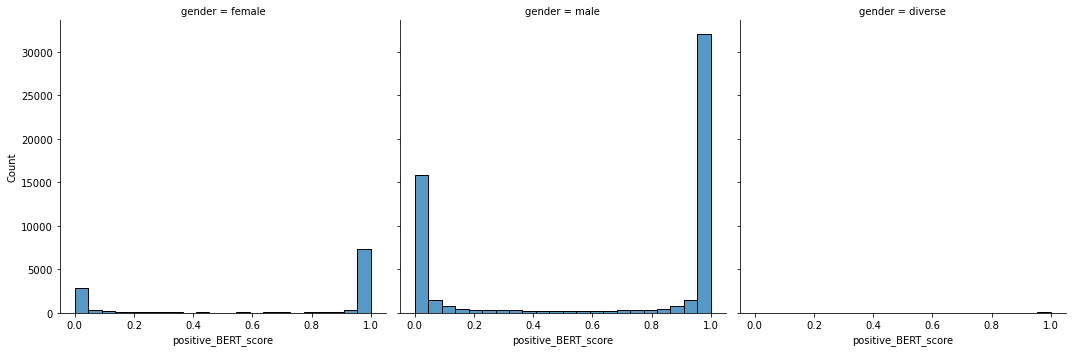

In [26]:
axs = sns.displot(df_quotes, x="positive_BERT_score", col="gender")

In [27]:
df_quotes[df_quotes['gender'] == 'male']['positive_BERT_score'].mean()

0.6407852775468535

In [28]:
df_quotes[df_quotes['gender'] == 'female']['positive_BERT_score'].mean()

0.6820884670783202

In [29]:
df_quotes[df_quotes['gender'] == 'male']['positive_BERT_score'].median()

0.9854506254196167

In [30]:
df_quotes[df_quotes['gender'] == 'female']['positive_BERT_score'].median()

0.9932129383087158

In [31]:
male_scores = df_quotes[df_quotes['gender'] == 'male']['positive_BERT_score']
female_scores = df_quotes[df_quotes['gender'] == 'female']['positive_BERT_score']
kstest(male_scores, female_scores, alternative='two-sided')

KstestResult(statistic=0.06161109192436376, pvalue=1.39040289512341e-33)

We decided for the Kolmogorov-Smirnoff two-sided test to compare the distributions of male and female sentiments. Given our p-value, we can reject the null hypothesis that both distributions are the same. From the higher mean and median of female sentiments, we would deduce that women tend to talk slightly more positive about movies than men do. 

In [32]:
male_movies = df_quotes[df_quotes['gender'] == 'male'].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})
male_medians = male_movies['median_sentiment']
male_movies.head(5)

,median_sentiment,no_of_quotes
movie,,
Fantastic Beasts and Where to Find Them,0.999506,42
Incredibles 2,0.999257,105
Fast & Furious 7,0.998885,21
Fantastic Beasts: The Crimes of Grindelwald,0.998581,193
Frozen II,0.998165,32


In [33]:
female_movies = df_quotes[df_quotes['gender'] == 'female'].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})
female_medians = female_movies['median_sentiment']
female_movies.head(5)

,median_sentiment,no_of_quotes
movie,,
Onward,0.999014,24
Fast & Furious 7,0.998901,2
Incredibles 2,0.998805,20
The Fate of the Furious,0.998448,8
Beauty and the Beast,0.998290,200


In [34]:
male_movies.sort_values('no_of_quotes', ascending=False).head()

,median_sentiment,no_of_quotes
movie,,
Star Wars: Episode VIII - The Last Jedi,0.985657,6818
Star Wars: Episode VII - The Force Awakens,0.992226,6337
Thor: Ragnarok,0.992318,5918
Avengers: Infinity War,0.929187,5212
Captain America: Civil War,0.911468,4181


In [35]:
female_movies.sort_values('no_of_quotes', ascending=False).head()

,median_sentiment,no_of_quotes
movie,,
Wonder Woman,0.998275,2082
Star Wars: Episode VIII - The Last Jedi,0.993809,1466
Star Wars: Episode VII - The Force Awakens,0.993798,1391
Thor: Ragnarok,0.991732,857
Black Panther,0.995702,814


Also, we can see that the movies that more than half of all quotes were positively speaking about deviate quite between men and women, with Fast & Furious 7 and Incredibles 2 being the only movies that appear in both top-5 collections. We are now interested in movies where men and women actually disagree, where majorities are positive for one and negative for the other group. 

In [36]:
diffs = (male_medians - female_medians).dropna().sort_values(ascending=False)
diffs.head(5)

movie
Deadpool          0.800372
Minions           0.197646
Venom             0.193294
Suicide Squad     0.182252
Jurassic World    0.045584
Name: median_sentiment, dtype: float64

In [37]:
diffs.tail(5)

movie
Birds of Prey: And the Fantabulous Emancipation of One Harley Quinn   -0.127122
Mission: Impossible - Fallout                                         -0.170463
Rogue One                                                             -0.306896
Zootopia                                                              -0.630630
Despicable Me 3                                                       -0.878912
Name: median_sentiment, dtype: float64

In this case, a very high (positive) difference of more than 0.5 means that more than 50 % of male quotes were positive, and more than 50 % of female quotes were negative, which apparently is the case for Deadpool. Accordingly, high negative differences that more than 50 % of female quotes were negative, and more than 50 % of female quotes were positive, which is the case for Despicable Me 3 and Zootopia. 

Let's investigate those two extreme movies (Deadpool and Despicable Me 3) a bit further to see what happens there.

In [38]:
df_quotes[(df_quotes['gender'] == 'male') & (df_quotes['movie'].isin(['Deadpool', 'Despicable Me 3']))].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})

,median_sentiment,no_of_quotes
movie,,
Deadpool,0.910349,1401
Despicable Me 3,0.114602,26


In [39]:
df_quotes[(df_quotes['gender'] == 'female') & (df_quotes['movie'].isin(['Deadpool', 'Despicable Me 3']))].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})

,median_sentiment,no_of_quotes
movie,,
Despicable Me 3,0.993513,5
Deadpool,0.109977,110


<AxesSubplot:ylabel='Frequency'>

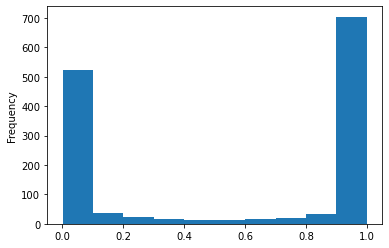

In [102]:
df_quotes[(df_quotes['gender'] == 'male') & (df_quotes['movie'] == 'Deadpool')]['positive_BERT_score'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

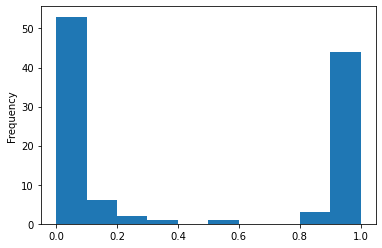

In [103]:
df_quotes[(df_quotes['gender'] == 'female') & (df_quotes['movie'] == 'Deadpool')]['positive_BERT_score'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

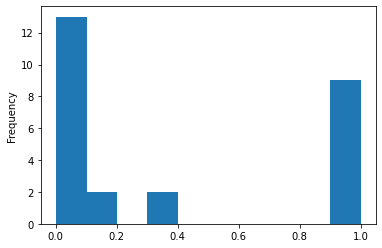

In [104]:
df_quotes[(df_quotes['gender'] == 'male') & (df_quotes['movie'] == 'Despicable Me 3')]['positive_BERT_score'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

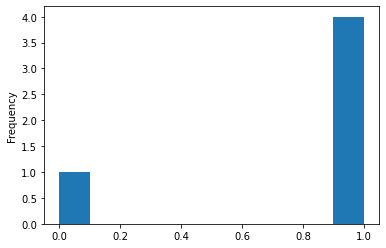

In [105]:
df_quotes[(df_quotes['gender'] == 'female') & (df_quotes['movie'] == 'Despicable Me 3')]['positive_BERT_score'].plot.hist()

In [106]:
df_quotes[df_quotes['movie'].isin(['Deadpool', 'Despicable Me 3'])].groupby('movie').agg({'positive_BERT_score': 'median', 'quotation': 'count'}).sort_values('positive_BERT_score', ascending=False).rename(columns={'positive_BERT_score': 'median_sentiment', 'quotation': 'no_of_quotes'})

,median_sentiment,no_of_quotes
movie,,
Deadpool,0.878795,1516
Despicable Me 3,0.168556,31


We deduce the following: It is actually the case that in both movies, a majority of male/female voters, respectively, are positive, while the opposite group is primarily negative towards the movie. Interestingly, when taking the overall median, would rather follow the male sentiment. This is of course due to the relative high number of male voters when compared to the number of female voters.

## Bias in Internet Movie Database ratings:

We also check the (un)biasedness of our second potentially biased dataset: The ratings from IMDb. Here, we check for a bias both in terms of gender and in terms of age groups. Let's see, how much influence majority groups in both properties might have on the total perception of a movie.

For our analysis, we were a bit limited by our dataset. The main problem is, that we only get a mean vote and the number of votes per group (e.g. male/female, age < 18, 18 to 30, ...). We are clearly missing a standard diviation here to make statistically valid statements about these topics in general. However, it is still possible for us to reason on a movie-by-movie basis.

We were trying to find other datasets, however, very few datasets (except for Quotebank and the imdb set) give information about the gender, ethnicity, age, etc. of a person. Our strongest candidate was the movielens dataset, but which only covers this information in a dataset with ratings from before 2003. 

In [2]:
movies = pd.read_csv('exploratory/data/IMDb/IMDb movies.csv')

/opt/miniconda3/envs/ada/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [42]:
ratings = pd.read_csv('exploratory/data/IMDb/IMDb ratings.csv')

In [43]:
def clean_imdb(df):
    imdb = df.rename(columns = {'worlwide_gross_income':'worldwide_gross_income'})
    imdb = imdb.drop(imdb.index[83917])
    imdb['year'] = imdb['year'].astype(int)
    imdb = imdb[imdb['year']>2014]
    imdb = imdb.dropna()
    imdb['budget'] = imdb['budget'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['worldwide_gross_income'] = imdb['worldwide_gross_income'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['usa_gross_income'] = imdb['usa_gross_income'].map(lambda x: x.lstrip('$EURCZKNYGBPWILSADMXNJPYOP')).astype(int)
    imdb['date_published'] = pd.to_datetime(imdb['date_published'])
    return imdb

movies = clean_imdb(movies)

In [44]:
def standardize_col(col):
    try:
        return (col - col.mean())/col.std()
    except:
        return col

In [45]:
movies.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worldwide_gross_income,metascore,reviews_from_users,reviews_from_critics
43822,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,"Chris Pratt, Bryce Dallas Howard, Irrfan Khan,...","A new theme park, built on the original site o...",7.0,569512,150000000,652270625,1670401444,59.0,1537.0,698.0
44619,tt0385887,Motherless Brooklyn - I segreti di una città,Motherless Brooklyn,2019,2019-11-07,"Crime, Drama, Mystery",144,USA,"English, French",Edward Norton,...,"Edward Norton, Gugu Mbatha-Raw, Alec Baldwin, ...","In 1950s New York, a lonely private detective ...",6.8,34759,26000000,9277736,18477736,60.0,319.0,178.0
46723,tt0437086,Alita - Angelo della battaglia,Alita: Battle Angel,2019,2019-02-14,"Action, Adventure, Sci-Fi",122,"USA, Japan, Canada","English, Spanish",Robert Rodriguez,...,"Rosa Salazar, Christoph Waltz, Jennifer Connel...","A deactivated cyborg is revived, but cannot re...",7.3,217183,170000000,85710210,404852543,53.0,2757.0,368.0
47132,tt0448115,Shazam!,Shazam!,2019,2019-04-03,"Action, Adventure, Comedy",132,"USA, Canada","English, Spanish",David F. Sandberg,...,"Zachary Levi, Mark Strong, Asher Angel, Jack D...",A newly fostered young boy in search of his mo...,7.1,240858,100000000,140371656,365971656,71.0,2009.0,379.0
47292,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,"Gal Gadot, Chris Pine, Connie Nielsen, Robin W...",When a pilot crashes and tells of conflict in ...,7.4,535903,149000000,412563408,821847012,76.0,2200.0,713.0


In [47]:
ratings.head()

,imdb_title_id,weighted_average_vote,total_votes,mean_vote,median_vote,votes_10,votes_9,votes_8,votes_7,votes_6,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0000009,5.9,154,5.9,6.0,12,4,10,43,28,...,5.7,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0
1,tt0000574,6.1,589,6.3,6.0,57,18,58,137,139,...,6.2,23.0,6.6,14.0,6.4,66.0,6.0,96.0,6.2,331.0
2,tt0001892,5.8,188,6.0,6.0,6,6,17,44,52,...,5.8,4.0,6.8,7.0,5.4,32.0,6.2,31.0,5.9,123.0
3,tt0002101,5.2,446,5.3,5.0,15,8,16,62,98,...,5.5,14.0,6.1,21.0,4.9,57.0,5.5,207.0,4.7,105.0
4,tt0002130,7.0,2237,6.9,7.0,210,225,436,641,344,...,7.3,82.0,7.4,77.0,6.9,139.0,7.0,488.0,7.0,1166.0


In [54]:
imdb = movies.merge(ratings, on='imdb_title_id')
imdb.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,7.2,32243.0,7.3,6381.0,6.8,762.0,7.1,72876.0,6.8,217418.0
1,tt0385887,Motherless Brooklyn - I segreti di una città,Motherless Brooklyn,2019,2019-11-07,"Crime, Drama, Mystery",144,USA,"English, French",Edward Norton,...,6.8,1632.0,7.1,837.0,6.3,269.0,6.8,5124.0,6.8,14796.0
2,tt0437086,Alita - Angelo della battaglia,Alita: Battle Angel,2019,2019-02-14,"Action, Adventure, Sci-Fi",122,"USA, Japan, Canada","English, Spanish",Robert Rodriguez,...,7.2,7651.0,7.5,1843.0,6.8,439.0,7.3,22680.0,7.2,83787.0
3,tt0448115,Shazam!,Shazam!,2019,2019-04-03,"Action, Adventure, Comedy",132,"USA, Canada","English, Spanish",David F. Sandberg,...,7.1,8995.0,7.3,2091.0,6.8,525.0,7.3,28394.0,6.9,85782.0
4,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,7.6,29053.0,7.8,7220.0,7.0,723.0,7.7,67709.0,7.2,190337.0


In [56]:
relevant_years = imdb[imdb['year'].isin(most_successful_movies.keys())]
relevant_years.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,2015,2015-06-11,"Action, Adventure, Sci-Fi",124,USA,English,Colin Trevorrow,...,7.2,32243.0,7.3,6381.0,6.8,762.0,7.1,72876.0,6.8,217418.0
1,tt0385887,Motherless Brooklyn - I segreti di una città,Motherless Brooklyn,2019,2019-11-07,"Crime, Drama, Mystery",144,USA,"English, French",Edward Norton,...,6.8,1632.0,7.1,837.0,6.3,269.0,6.8,5124.0,6.8,14796.0
2,tt0437086,Alita - Angelo della battaglia,Alita: Battle Angel,2019,2019-02-14,"Action, Adventure, Sci-Fi",122,"USA, Japan, Canada","English, Spanish",Robert Rodriguez,...,7.2,7651.0,7.5,1843.0,6.8,439.0,7.3,22680.0,7.2,83787.0
3,tt0448115,Shazam!,Shazam!,2019,2019-04-03,"Action, Adventure, Comedy",132,"USA, Canada","English, Spanish",David F. Sandberg,...,7.1,8995.0,7.3,2091.0,6.8,525.0,7.3,28394.0,6.9,85782.0
4,tt0451279,Wonder Woman,Wonder Woman,2017,2017-06-01,"Action, Adventure, Fantasy",141,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,7.6,29053.0,7.8,7220.0,7.0,723.0,7.7,67709.0,7.2,190337.0


In [57]:
relevant_years_stdz = relevant_years.apply(standardize_col, axis=0)
relevant_years_stdz.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0369610,Jurassic World,Jurassic World,-1.294172,-1.536841,"Action, Adventure, Sci-Fi",0.825079,USA,English,Colin Trevorrow,...,0.790351,4.058516,0.775531,3.418174,1.123500,2.733679,0.702649,4.208965,0.515443,3.712219
1,tt0385887,Motherless Brooklyn - I segreti di una città,Motherless Brooklyn,1.466543,1.511622,"Crime, Drama, Mystery",2.011445,USA,"English, French",Edward Norton,...,0.330721,-0.544581,0.545030,-0.317413,0.574413,-0.194279,0.381114,-0.396925,0.515443,-0.444035
2,tt0437086,Alita - Angelo della battaglia,Alita: Battle Angel,1.466543,1.007963,"Action, Adventure, Sci-Fi",0.706443,"USA, Japan, Canada","English, Spanish",Robert Rodriguez,...,0.790351,0.360520,1.006031,0.360437,1.123500,0.815362,0.917006,0.796560,0.951976,0.971133
3,tt0448115,Shazam!,Shazam!,1.466543,1.098849,"Action, Adventure, Comedy",1.299625,"USA, Canada","English, Spanish",David F. Sandberg,...,0.675443,0.562623,0.775531,0.527541,1.123500,1.326121,0.917006,1.185007,0.624576,1.012055
4,tt0451279,Wonder Woman,Wonder Woman,0.086185,-0.171660,"Action, Adventure, Fantasy",1.833490,"USA, China, Hong Kong","English, German, Dutch, French, Spanish, Chine...",Patty Jenkins,...,1.249981,3.578824,1.351782,3.983498,1.343135,2.502056,1.345719,3.857704,0.951976,3.156724


First, we check the distribution among mean percentages of male voters per movie. 

0.5802392635264324

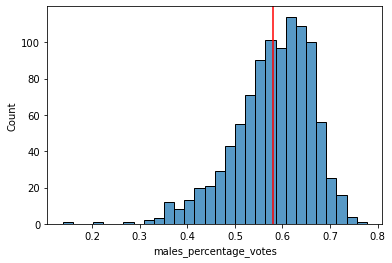

In [59]:
relevant_years['males_percentage_votes'] = relevant_years['males_allages_votes'] / relevant_years['votes']
#relevant_years['males_percentage_votes'].plot.hist(bins=50)
sns.histplot(data=relevant_years, x='males_percentage_votes')
plt.axvline(x=relevant_years['males_percentage_votes'].mean(),
            color='red')
relevant_years['males_percentage_votes'].mean()

We observe a slightly left-skewed distribution, with a mean of .58, while we would expect a mean of 0.5. 
We can therefore test whether the mean of 0.58 is significantly different from 0.5, which we consider the distribution of male and females in the world (our population). For this, the two-sided 1-sample ttest is a perfect match.

In [60]:
ttest_1samp(relevant_years['males_percentage_votes'], 0.5)

Ttest_1sampResult(statistic=30.859035907939063, pvalue=4.013537684447491e-147)

The p value let's us reject the Null Hypothesis that females and males are equally (50 % each) in the number of ratings. Hence, the averages tend to cover more male reviewers than female reviewers. We would derive from this result that average scores might be biased towards male opinions. 

Let's have a look at the left and right extremes, just to see what kinds of movies that might be. It looks like there are 3 movies with very low male percentage and 1-5 with a very high. So, we just have a look at the 5 highest and lowest percentage of male votes.

In [61]:
relevant_years[['original_title','males_percentage_votes']].sort_values('males_percentage_votes').head(5)

,original_title,males_percentage_votes
566,Meet the Blacks,0.137320
552,After,0.215840
706,"Everything, Everything",0.278886
548,Forever My Girl,0.327401
855,The Sun Is Also a Star,0.328246


In [62]:
relevant_years[['original_title','males_percentage_votes']].sort_values('males_percentage_votes', ascending=False).head(5)

,original_title,males_percentage_votes
500,Mai sing,0.777633
279,The Gunman,0.748229
466,Turbo Kid,0.746878
730,Kickboxer: Retaliation,0.739533
502,Cop Car,0.736558


## How successful are movies liked by men/women?

As a first step, we analyze the influence of the average vote by men and women on the total mean. For this, we fit an OLS model to predict the total mean and have a look at the coefficients. 

In [133]:
mod = smf.ols(formula='mean_vote ~ females_allages_avg_vote + males_allages_avg_vote', data=relevant_years_stdz)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              mean_vote   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     8391.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:23:34   Log-Likelihood:                 25.248
No. Observations:                 993   AIC:                            -44.50
Df Residuals:                     990   BIC:                            -29.79
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In this case, we see a strong influence of both averages. We would deduce that both averages have significant influence on the total mean of votes for a movie. 

In [90]:
pearsonr(our_movies['females_allages_avg_vote'], our_movies['mean_vote'])

(0.9375038766751962, 2.0150238375185858e-26)

In [139]:
pearsonr(our_movies['males_allages_avg_vote'], our_movies['mean_vote'])

(0.9815546707485967, 1.7362855691709982e-40)

[None]

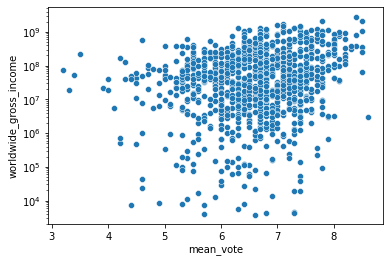

In [136]:
ax = sns.scatterplot(x='mean_vote', y='worldwide_gross_income', data=relevant_years)
ax.set(yscale='log')

From this plot, we see no direct correlation between the mean vote of a movie and its success in terms of income (a shame...). We would therefore argue that the income of a movie is also independent of the average vote by male and female reviewers. For completeness, we also add the two plots with male and female average votes, underlying our hypothesis:

[None]

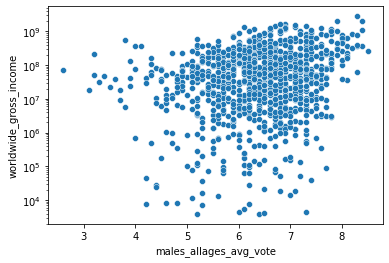

In [137]:
ax = sns.scatterplot(x='males_allages_avg_vote', y='worldwide_gross_income', data=relevant_years)
ax.set(yscale='log')

[None]

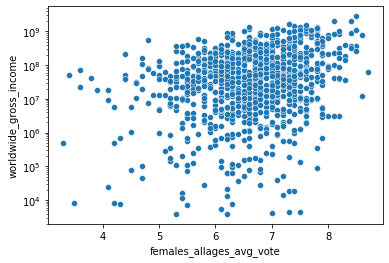

In [138]:
ax = sns.scatterplot(x='females_allages_avg_vote', y='worldwide_gross_income', data=relevant_years)
ax.set(yscale='log')

## Average vote by men?

Let's see if the trend from the quotebank data is agreed on here: That men are on average giving lower scores than women. The distribution of average votes on movies by men or women might indicate so. 

Let us be very clear with the hypothesis to check here: We want to check whether the mean rating score on a movie is significantlly different between female and male voters. 

In [49]:
ratings['males_allages_avg_vote'].mean()

5.817172176019604

In [50]:
ratings['females_allages_avg_vote'].mean()

6.0394082122788

<AxesSubplot:ylabel='Frequency'>

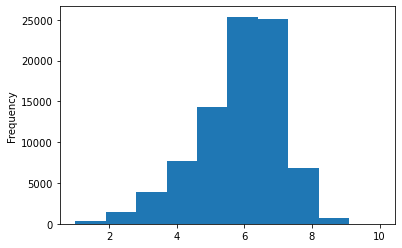

In [51]:
ratings['males_allages_avg_vote'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

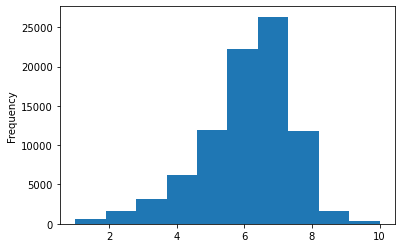

In [52]:
ratings['females_allages_avg_vote'].plot.hist()

6.355991943605238

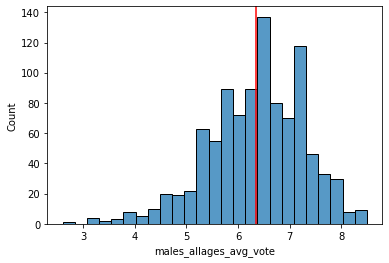

In [92]:
sns.histplot(data=relevant_years, x='males_allages_avg_vote')
plt.axvline(x=relevant_years['males_allages_avg_vote'].mean(),
            color='red')
relevant_years['males_allages_avg_vote'].mean()

6.598791540785492

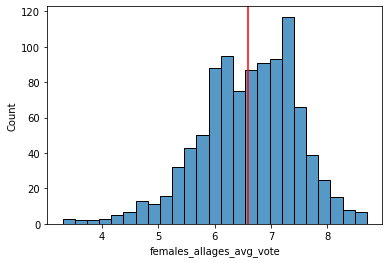

In [93]:
sns.histplot(data=relevant_years, x='females_allages_avg_vote')
plt.axvline(x=relevant_years['females_allages_avg_vote'].mean(),
            color='red')
relevant_years['females_allages_avg_vote'].mean()

Set equal_var to False to not assume that both distributions have an equal variance.

In [94]:
ttest_ind(relevant_years['males_allages_avg_vote'], relevant_years['females_allages_avg_vote'], equal_var=False)

Ttest_indResult(statistic=-6.004186697377894, pvalue=2.282261102655337e-09)

Our test shows us that with high probability, we can reject the null hypothesis that the avg votes of male and female voters per movie are on expectation the same. Hence, we conclude that they the average vote per movie by men is on average lower than by women. N.b. that this does not say anything about single votes, just about this summary statistic of groups of votes. 

## Young vs old generation? Which generation influences movie success the most?

As last, we assess if there are age groups that have more influence on the topic than others. We first check the influence of these on the total mean per movie by fitting linear regression and checking the coefficients.
We see that among all voters, people between 18 and 30 (allgenders_18age_votes) and people between 30 and 45 (allgenders_30age_votes) make up for the majority of voters in total. Also, as seen from all histograms over all movies, we can see that for a big number of movies, the groups of 18-30 or 30-45 years old are the majority of voters.

In [98]:
for col_name in ['allgenders_0age_votes','allgenders_18age_votes','allgenders_30age_votes','allgenders_45age_votes']:
    print('{}: {}'.format(col_name, sum(our_movies[col_name])))

allgenders_0age_votes: 41862.0
allgenders_18age_votes: 5032506.0
allgenders_30age_votes: 6762294.0
allgenders_45age_votes: 1563054.0


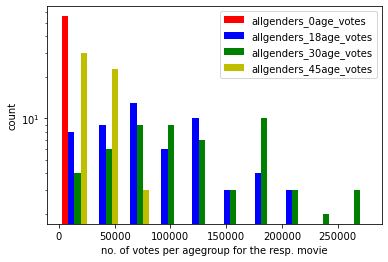

In [99]:
col_names = ['allgenders_0age_votes','allgenders_18age_votes','allgenders_30age_votes','allgenders_45age_votes']
plt.hist([our_movies[col_name] for col_name in col_names], color=['r','b', 'g', 'y'], log=True, label=col_names)
plt.legend()
plt.ylabel('count')
plt.xlabel('no. of votes per agegroup for the resp. movie');

In [110]:
mod = smf.ols(formula='mean_vote ~ allgenders_0age_avg_vote + allgenders_18age_avg_vote + allgenders_30age_avg_vote + allgenders_45age_avg_vote', data=relevant_years_stdz)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              mean_vote   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     3641.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:20:14   Log-Likelihood:                -23.888
No. Observations:                 969   AIC:                             57.78
Df Residuals:                     964   BIC:                             82.16
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

However, when taking a look at the linear regression model to predict the total mean of votes from the mean in each agegroup, it turns out that only 18-30 years old and 45 and older have a significant influence on the mean of all votes. While we would expect such a result for the (highly underrepresented, only 40k Votes in total) group of < 18 years old, we are very surprised that the group of 30-45 years old has no significant influence on the overall rating of the movie. 

<AxesSubplot:xlabel='allgenders_30age_avg_vote', ylabel='mean_vote'>

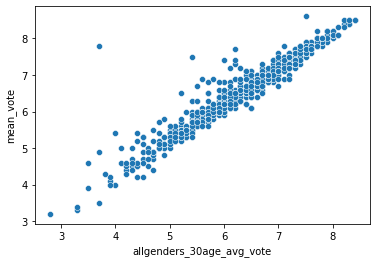

In [128]:
sns.scatterplot(x='allgenders_30age_avg_vote', y='mean_vote', data=relevant_years)

<AxesSubplot:xlabel='allgenders_0age_avg_vote', ylabel='mean_vote'>

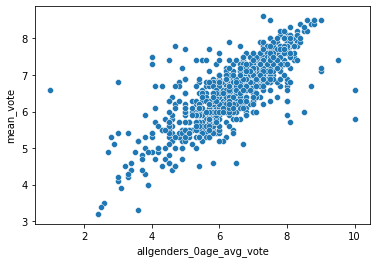

In [129]:
sns.scatterplot(x='allgenders_0age_avg_vote', y='mean_vote', data=relevant_years)

In [120]:
pearsonr(relevant_years['allgenders_30age_avg_vote'], relevant_years['mean_vote'])

(0.960694453148333, 0.0)

In [125]:
pearsonr(relevant_years['allgenders_0age_avg_vote'].fillna(0), relevant_years['mean_vote'])

(0.6369770049233461, 4.02247779398276e-114)

For these two groups, we further investigate their influence on the mean. For both, we get high values of pearson r, with a nearly 1 value for the group between 30 and 45. We might deduce the following: The group of 30-45 seems to be closely following the average vote, being about on the same level. However, high average means are only achieved when either 18-30 or 45+ ages vote good on movies, at least on average for single movies. 